In [2]:
from __future__ import division
%matplotlib inline
from datetime import datetime
from dateutil import parser
import glob
import math
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = (8.0, 8.0)
import pkg_resources
import time

import CameraNetwork
import CameraNetwork.global_settings as gs
import CameraNetwork.sunphotometer as spm

In [5]:
client = CameraNetwork.CLIclient()
proxy_params = CameraNetwork.retrieve_proxy_parameters()
client.start(proxy_params)
time.sleep(3)
SERVERS = client.client_instance.servers

## Set of servers and date

In [6]:
SERVERS = ["109", "110", "111", "112", "113", "114", "115"]

## Do extrinsic calibration for the specific day

In [7]:
extrinsic_day = datetime(2017, 2, 25)
results = client.extrinsic(SERVERS, extrinsic_day, 0.05, True)

## Do radiometric calibration for the specific day

In [6]:
radiometric_day = datetime(2017, 2, 25)
base_path = pkg_resources.resource_filename(
    'CameraNetwork',
    '../data/aeronet/{}/*.alm'.format(radiometric_day.strftime("%Y_%m"))
)
path = glob.glob(base_path)
df = spm.parseSunPhotoMeter(path[0])
spm_df = df[radiometric_day.strftime("%Y-%m-%d")]
spm_df = [spm_df[spm_df["Wavelength(um)"]==wl] for wl in (0.6744, 0.5000, 0.4405)]
items = [d.strftime("%H:%M:%S") for d in spm_df[0].index]
items

['05:35:48',
 '06:01:39',
 '06:59:07',
 '07:58:57',
 '08:59:20',
 '10:00:02',
 '10:59:11',
 '11:58:54',
 '12:59:24',
 '13:56:59',
 '14:32:25']

In [14]:
results = client.radiometric(SERVERS, radiometric_day, 3, 5, True)

109 [0.092908794401048947, 0.093622932951165305, 0.097736207833466315]
110 [0.079362500537369332, 0.074890883343033177, 0.079442138369226672]
111 [0.069220001139308901, 0.079269529752779927, 0.080260759193706316]
112 [0.10221598982038159, 0.11131912192390493, 0.11204982009240091]
113 [0.078048583408977482, 0.074550263610261555, 0.074090239109044082]
114 [0.099243027258187164, 0.10002087550902775, 0.095057341829114086]
115 [0.075161367493727108, 0.097664438774497375, 0.10540213187680346]


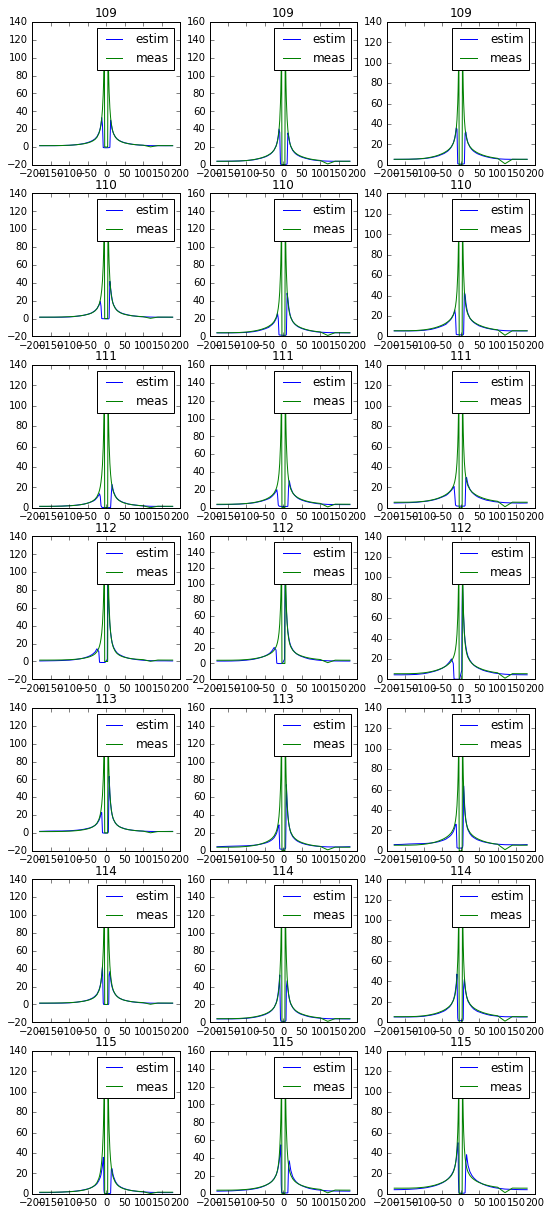

In [15]:
f, ax = plt.subplots(ncols=3, nrows=len(SERVERS), figsize=(9, len(SERVERS)*3))
for i, server_id in enumerate(SERVERS):
    angles = results[1][i]["angles"]
    estimations = results[1][i]["estimations"]
    measurements = results[1][i]["measurements"]
    ratios = results[1][i]["ratios"]
    print server_id, ratios
    for j in range(3):
        ax[i, j].plot(angles, estimations[j], label="estim")
        ax[i, j].plot(angles, measurements[j], label="meas")
        ax[i, j].legend()
        ax[i, j].set_title(server_id)

## Get images of clear sky

In [8]:
check_day = "2017-02-26 14:05:00"
_ = client.query(SERVERS, check_day)
results = client.seek(SERVERS, check_day, hdr_index="2", jpeg=False, resolution=101)

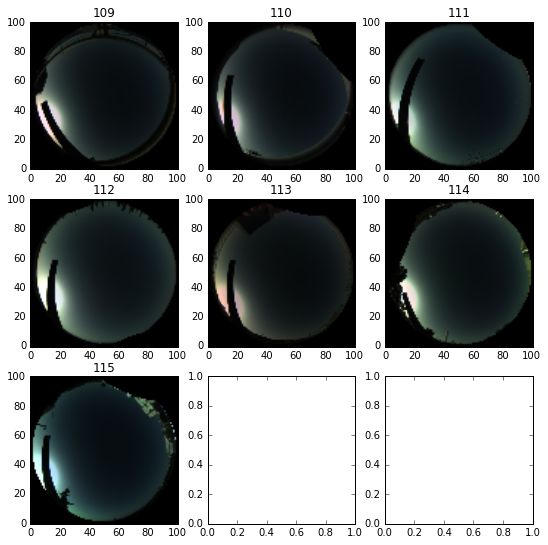

In [9]:
nrows = int(math.ceil(len(results[0])/3))
_, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(nrows*3, 9))
for server_id, img, ax in zip(SERVERS, results[0], axes.flatten()):
    img = np.clip(img, 0, 50)
    ax.imshow((img/img.max()*255).astype(np.uint8), origin="bottom")
    ax.set_title(server_id)

## Fixing moved cameras

We try to reconstruct a cloud from the 